<a href="https://www.kaggle.com/code/aleksandrmorozov123/deep-learning-for-nlp?scriptVersionId=191444213" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/analyst_ratings_processed.csv
/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_analyst_ratings.csv
/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_partner_headlines.csv
/kaggle/input/lfwpeople/pairsDevTrain.txt
/kaggle/input/lfwpeople/lfw-funneled.tgz
/kaggle/input/lfwpeople/pairsDevTest.txt
/kaggle/input/lfwpeople/pairs.txt


**Checking statistics of the Corpus**

In [2]:
# import required libraries
import pandas as pd

# we get first 10 000 values for fast running
ratings = pd.read_csv ('/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_analyst_ratings.csv')[0:10000]
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   headline    10000 non-null  object
 2   url         10000 non-null  object
 3   publisher   10000 non-null  object
 4   date        10000 non-null  object
 5   stock       10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [3]:
# comparing the text of two selected ratings
print (repr(ratings.iloc[3399]['headline'][0:300]))
print (repr(ratings.iloc[5487]['headline'][0:300]))

'Goldman Sachs Upgrades Alcoa To Buy, Raises Price Target (AA)'
"45 Stocks Moving In Thursday's Mid-Day Session"


In [4]:
# ignore spaces after the stop words
import re
ratings ["paragraphs"] = ratings ["headline"].map (lambda text: re.split ('[.?!]\s*\n', text))
ratings ['number_of_paragraphs'] = ratings ["paragraphs"].map (len)

**Preparations**

In [5]:
# import required libraries
import sklearn
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.de.stop_words import STOP_WORDS

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
vectors_text = tfidf_text_vectorizer.fit_transform (ratings ['headline'])
vectors_text.shape

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(10000, 10390)

In [6]:
# flatten the paragraphs keeping the sentiment
paragraph_df = pd.DataFrame ([{'headline': paragraph, 'publisher': publisher}
                             for paragraphs, publisher in \
                             zip (ratings ['paragraphs'], ratings ['publisher'])
                             for paragraph in paragraphs if paragraph])
tfidf_para_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform (paragraph_df ['headline'])
tfidf_para_vectors.shape

(10000, 10390)

**Nonnegative matrix factorization** - $ V \approx W \cdot H $

In [7]:
# import required library
from sklearn.decomposition import NMF

nmf_text_model = NMF (n_components = 10, random_state = 42)
W_text_matrix = nmf_text_model.fit_transform (vectors_text)
H_text_matrix = nmf_text_model.components_

# define a function for outputtin a summary
def display_topics (model, features, no_top_words=5):
    for topic, word_vector in enumerate (nmf_text_model.components_):
        total = word_vector.sum ()
        largest = word_vector.argsort ()[::-1]  # invert sort order
        print ("\ntopic %02d" % topic)
        for i in range (0, no_top_words):
            print ("  %s (%2.2f)" % (features [largest [i]],
                                    word_vector [largest[i]] * 100.0/total))
            
# calling the function
display_topics (nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


In [8]:
# normalizing topics
W_text_matrix.sum (axis=0)/W_text_matrix.sum()*100.0

array([11.13196912,  8.00564702, 11.05637611,  7.44085955, 12.66282551,
        7.01938348, 19.55898997,  6.65466007,  7.39061878,  9.07867037])

**Create a topic model for paragraphs using NMF**

In [9]:
nmf_para_model = NMF (n_components = 10, random_state = 42)
W_para_matrix = nmf_para_model.fit_transform (tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

display_topics (nmf_para_model, tfidf_para_vectorizer.get_feature_names_out ())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


**Latent semantic analysis with singular value decomposition** - any $ m \times n $ matrix V can be decomposed as follows
$V = U \cdot \Sigma \cdot V^* $

In [10]:
# import required module
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD (n_components = 10, random_state = 42)
W_svd_para_matrix = svd_para_model.fit_transform (tfidf_para_vectors)
H_svd_para_matrix = svd_para_model.components_

display_topics (svd_para_model, tfidf_para_vectorizer.get_feature_names_out ())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


**Latent Dirichlet Allocation**

In [11]:
# import required modules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

count_para_vectorizer = CountVectorizer (stop_words=list(STOP_WORDS))
count_para_vectors = count_para_vectorizer.fit_transform (paragraph_df ['headline'])

lda_para_model = LatentDirichletAllocation (n_components = 10, random_state = 42)
W_lda_para_matrix = lda_para_model.fit_transform (count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

display_topics (lda_para_model, tfidf_para_vectorizer.get_feature_names_out ())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


**Create Word Clouds to display and compare topic models**

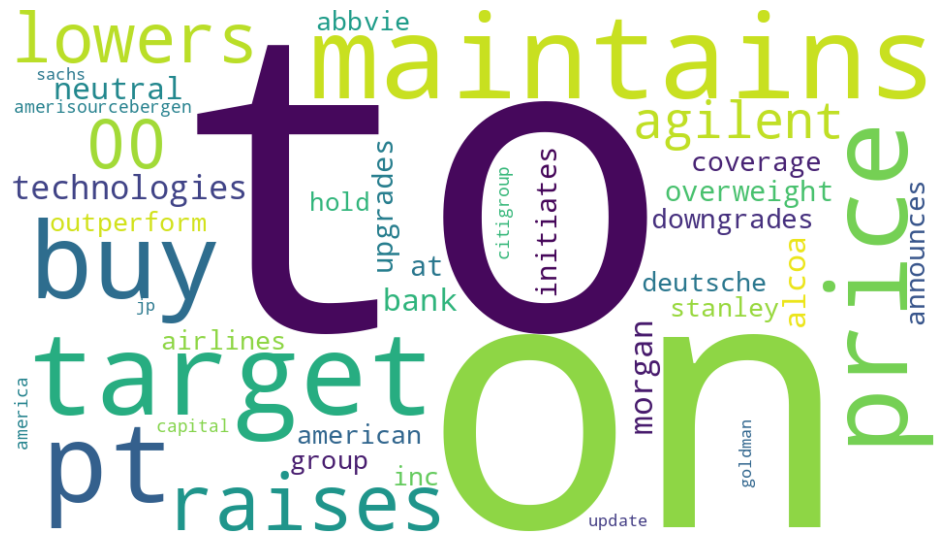

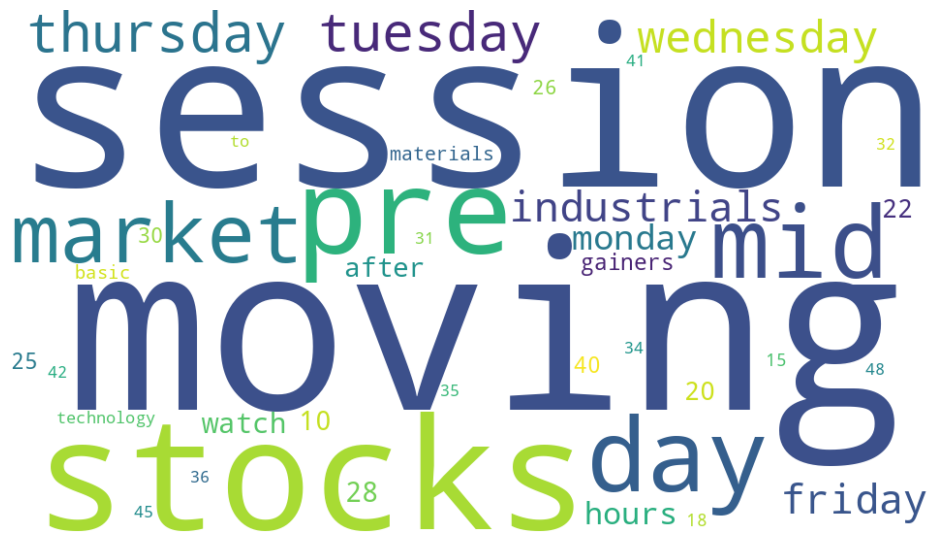

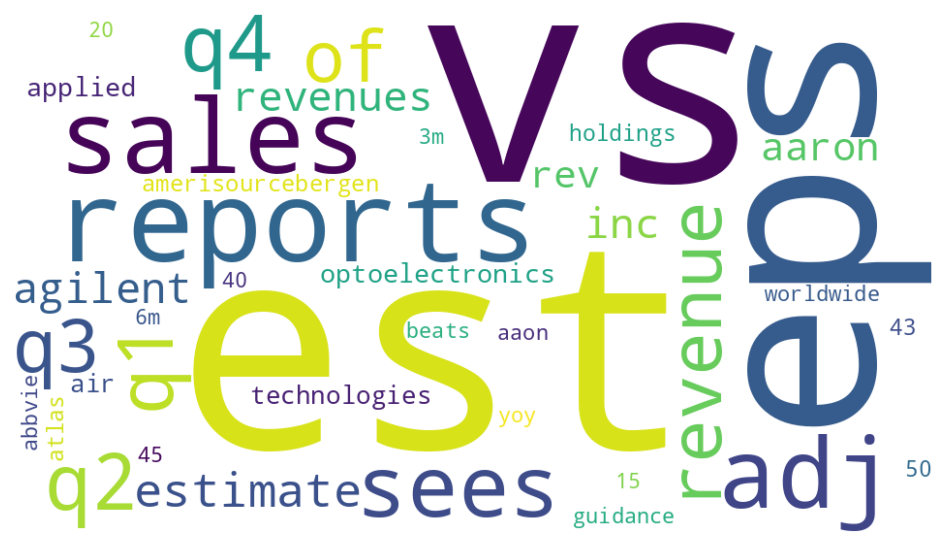

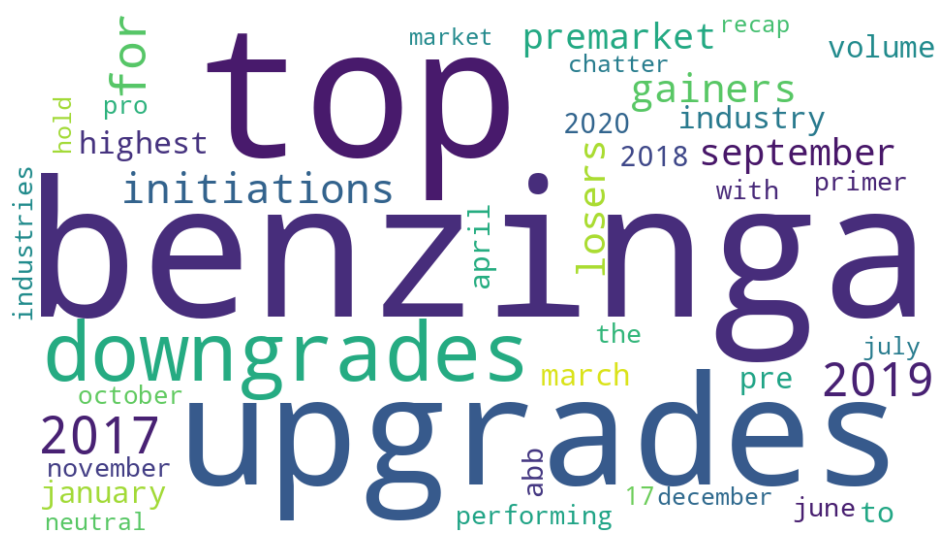

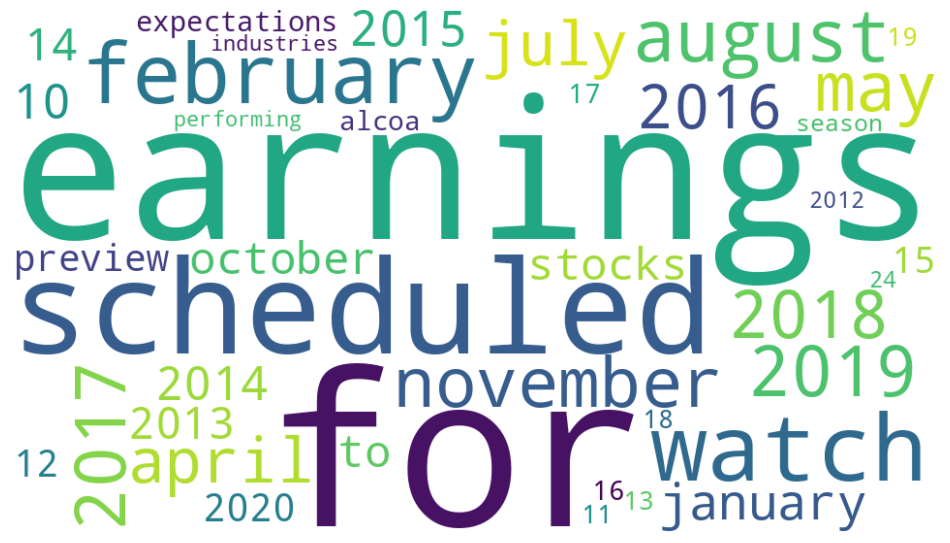

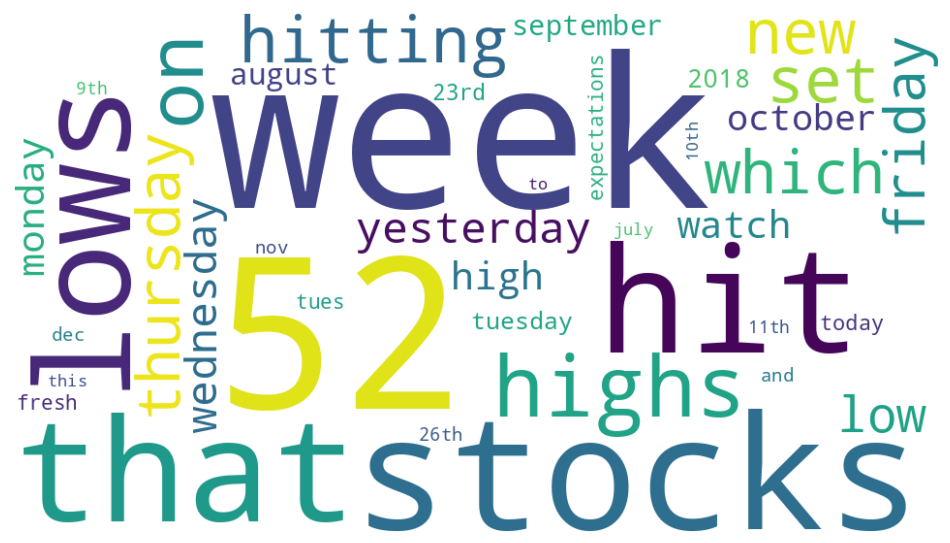

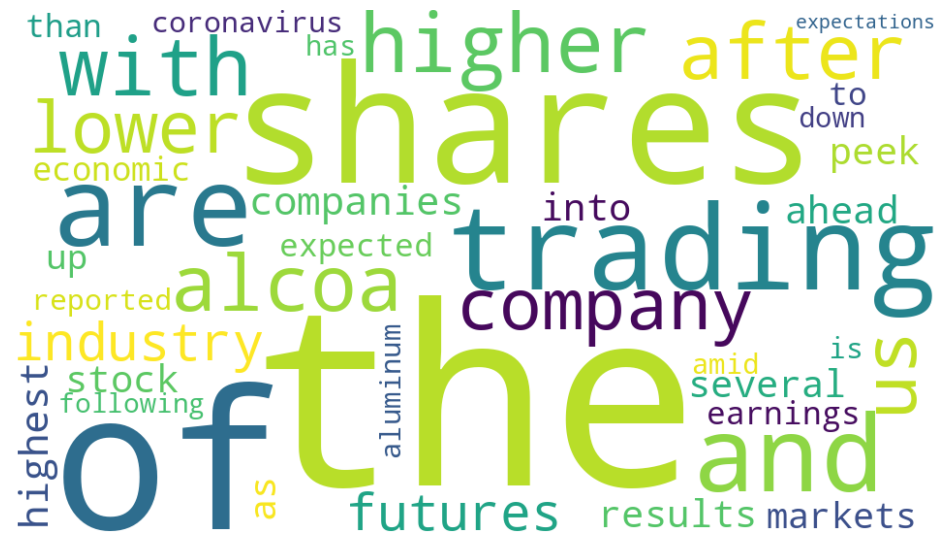

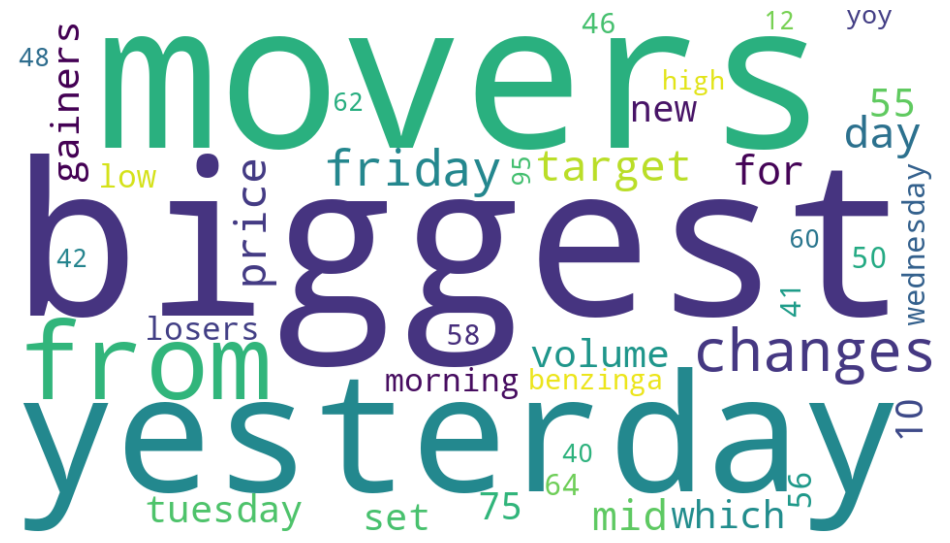

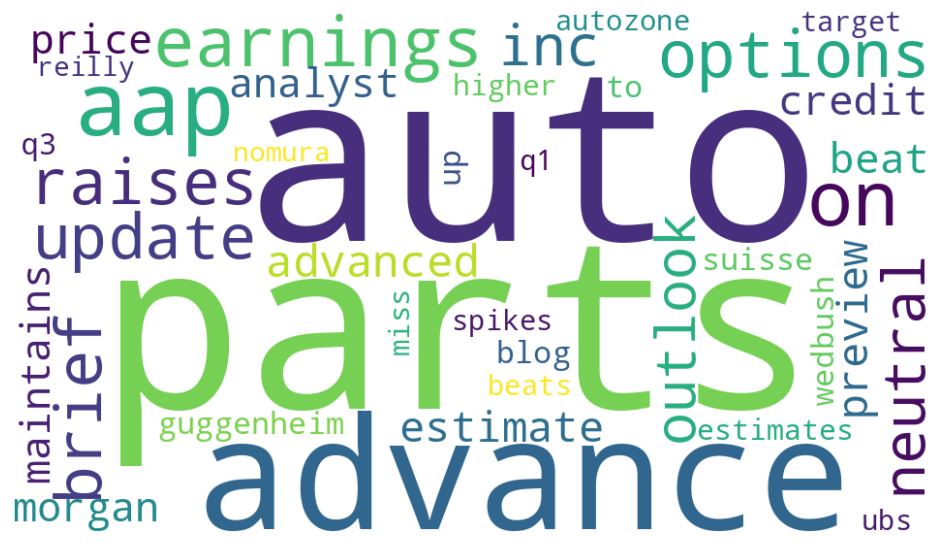

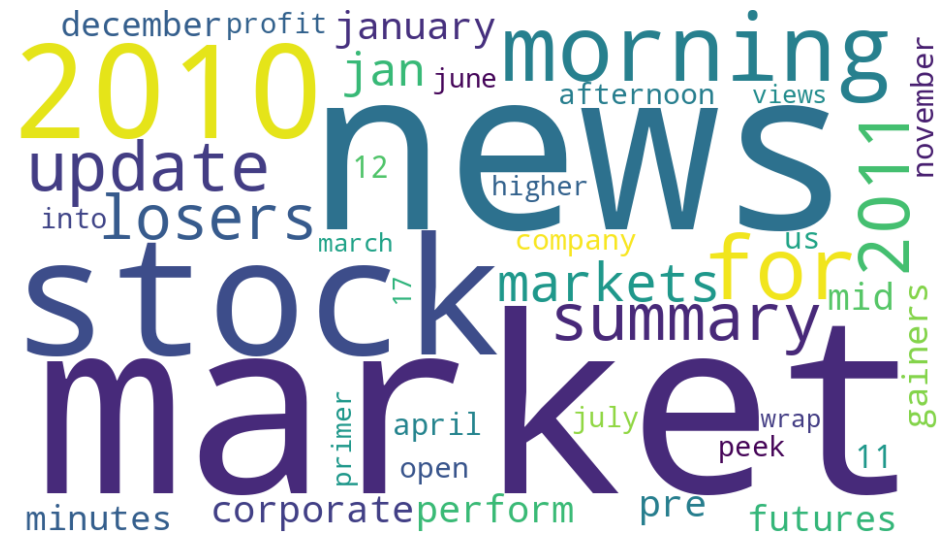

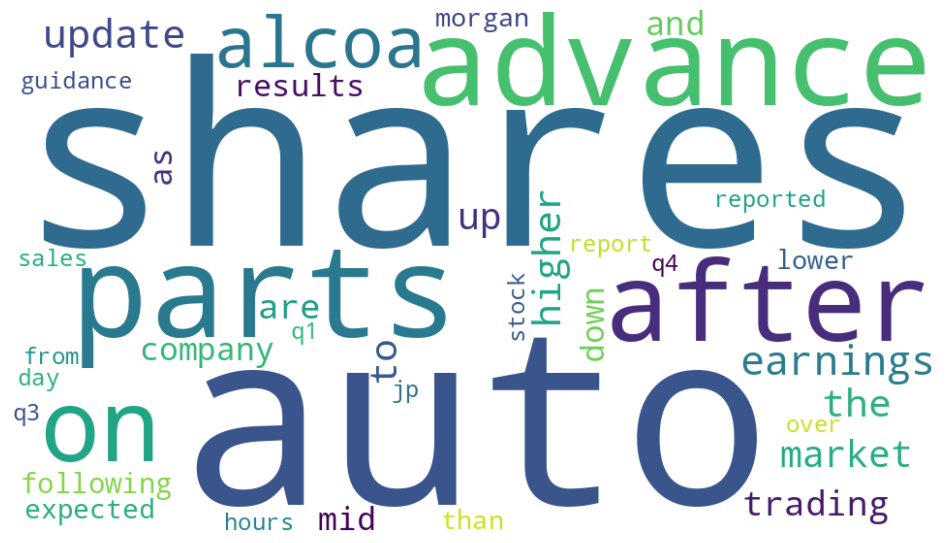

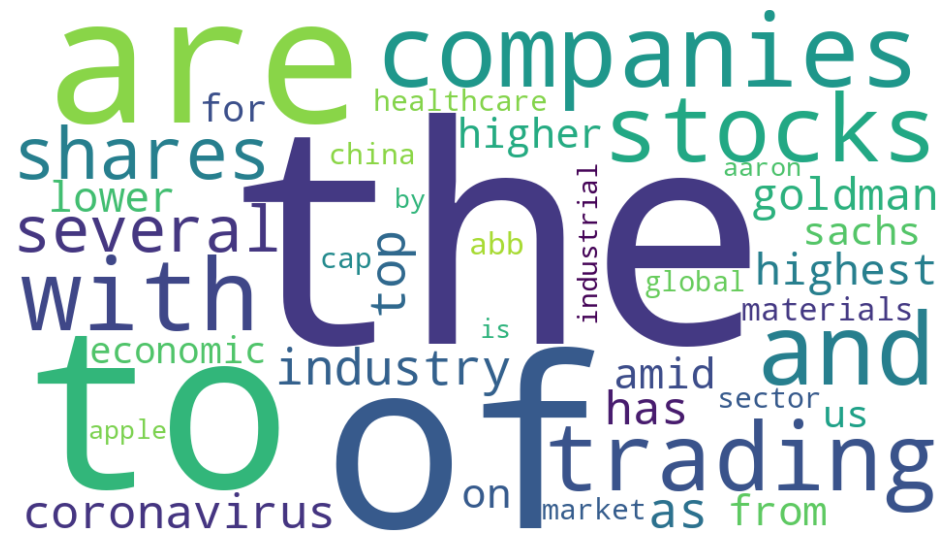

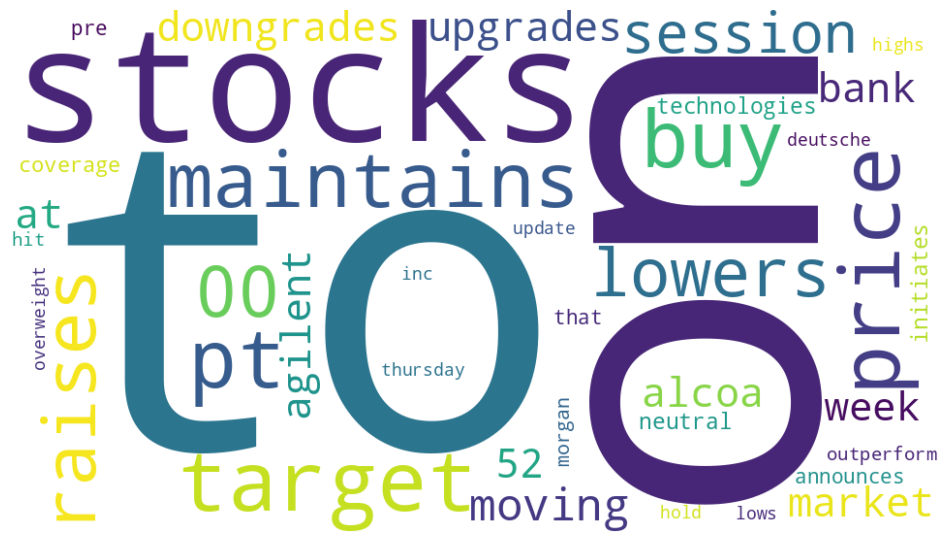

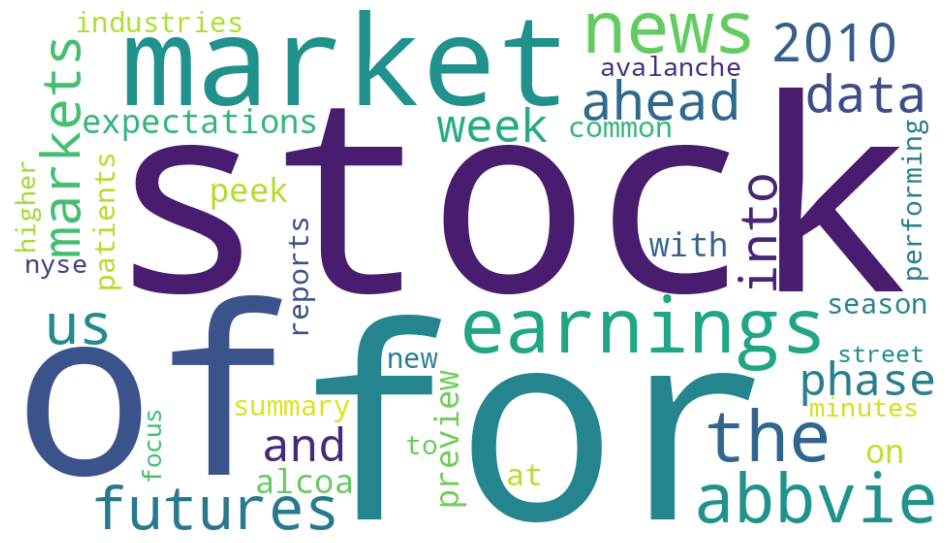

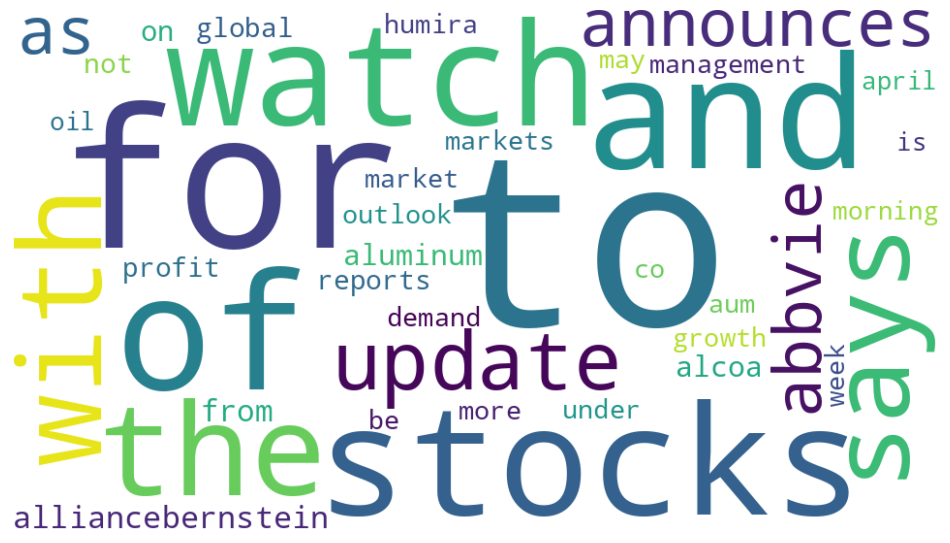

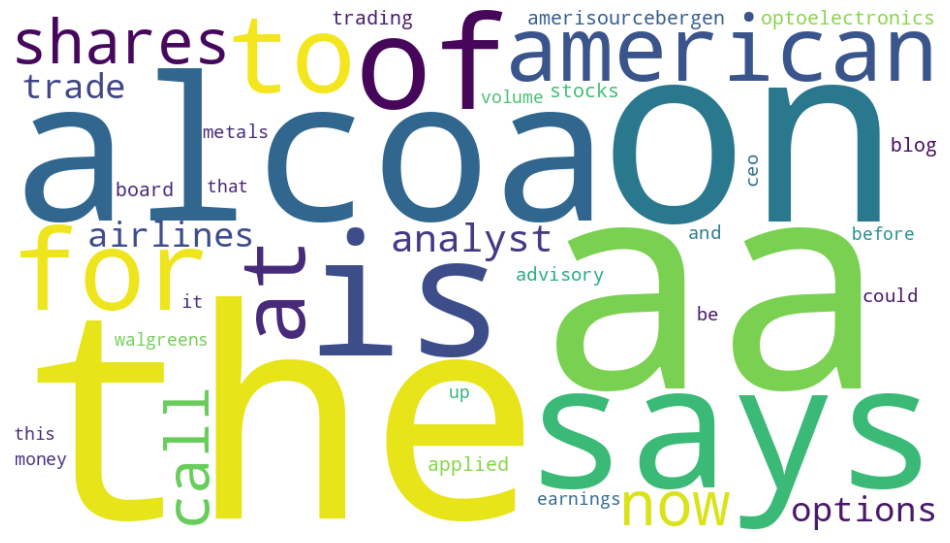

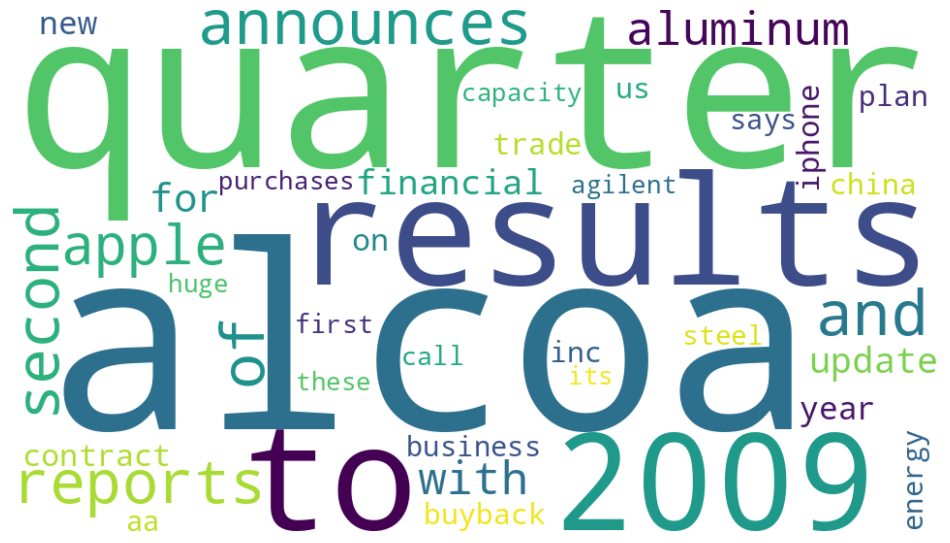

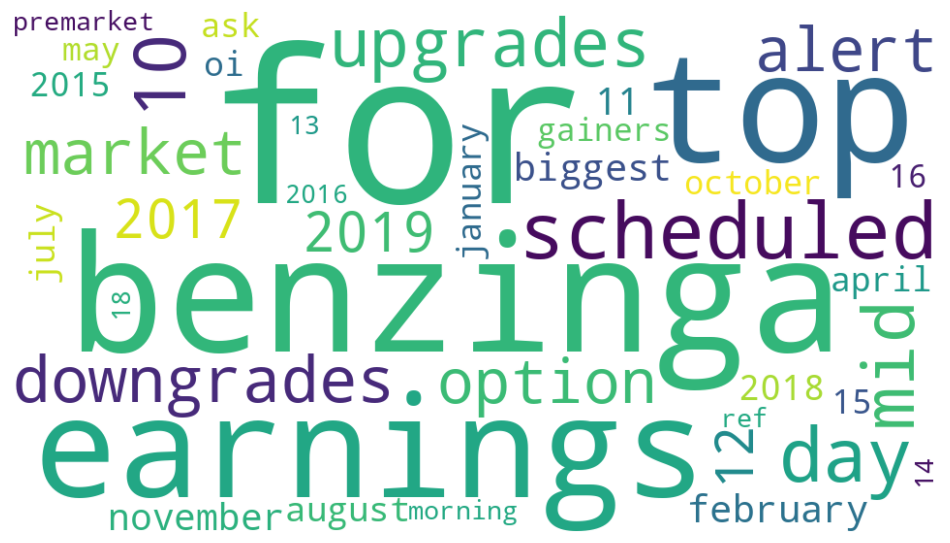

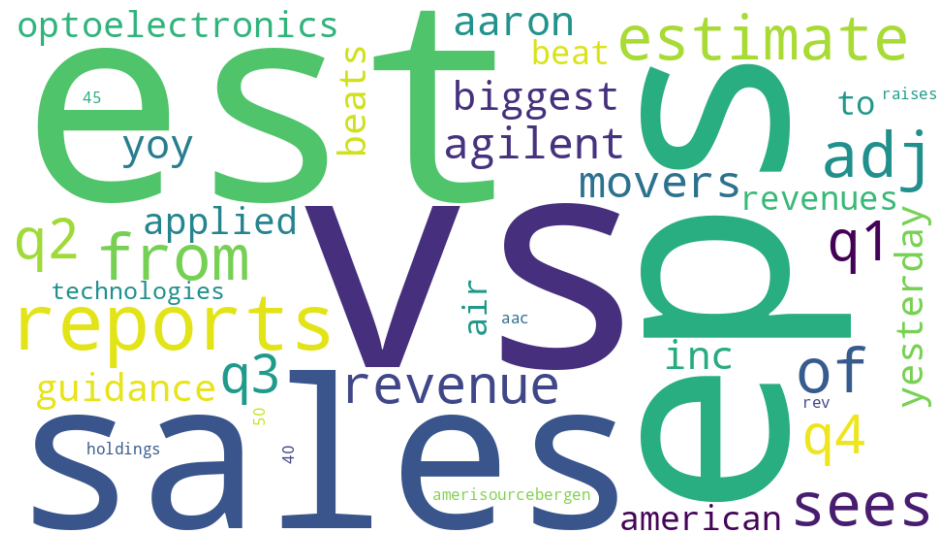

In [12]:
# import required libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics (model, features, no_top_words = 40):
    for topic, words in enumerate (model.components_):
        size = {}
        largest = words.argsort ()[::-1]  # invert sort order
        for i in range (0, no_top_words):
            size [features [largest [i]]] = abs (words [largest [i]])
        wc = WordCloud (background_color = "white", max_words = 100,
                       width = 960, height = 540)
        wc.generate_from_frequencies (size)
        plt.figure (figsize = (12, 12))
        plt.imshow (wc, interpolation = 'bilinear')
        plt.axis ('off')
        
# compare NMF and LDA model
wordcloud_topics (nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())
wordcloud_topics (lda_para_model, count_para_vectorizer.get_feature_names_out ())

**Building a neural network using Pytorch**

In [13]:
# import required libraries
import torch
import torch.nn as nn

x = [[2, 5], [7, 9], [4, 8], [6, 9]]
y = [[4], [9], [12], [17]]

X = torch.tensor (x).float ()
Y = torch.tensor (y).float ()

device = 'cuda' if torch.cuda.is_available () else 'cpu'
X = X.to(device)
Y = Y.to(device)

class MyNeuralNet (nn.Module):
    def __init__(self):
        super().__init__()
        self.input_to_hidden_layer = nn.Linear (2, 8)
        self.hidden_layer_activation = nn.ReLU()
        self.hidden_to_output_layer = nn.Linear (8, 1)
    def forward (self, x):
        x = self.input_to_hidden_layer (x)
        x = self.hidden_layer_activation (x)
        x = self.hidden_to_output_layer (x)
        return x
    
mynet = MyNeuralNet().to(device)
loss_func = nn.MSELoss()

_Y = mynet(X)
loss_value = loss_func (_Y, Y)
print (loss_value)

tensor(141.2271, device='cuda:0', grad_fn=<MseLossBackward0>)


Text(0, 0.5, 'loss value')

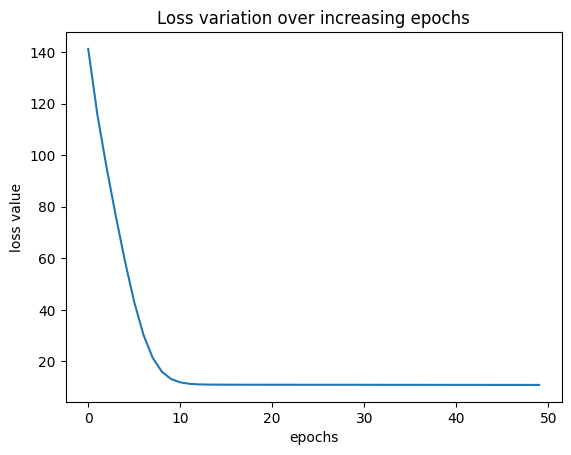

In [14]:
from torch.optim import SGD
import matplotlib.pyplot as plt
%matplotlib inline

opt = SGD (mynet.parameters(), lr = 0.001)

loss_history = []
for _ in range(50):
    opt.zero_grad()
    loss_value = loss_func (mynet (X), Y)
    loss_value.backward ()
    opt.step ()
    loss_history.append (loss_value.item())
    
plt.plot(loss_history)
plt.title ('Loss variation over increasing epochs')
plt.xlabel ('epochs')
plt.ylabel ('loss value')

**Resnet block architecture**

In [15]:
import torch
from torch import nn

class ResLayer (nn.Module):
    def __init__ (self, ni, no, kernel_size, stride=1):
        super (ResLayer, self).__init__()
        padding = kernel_size - 2
        self_conv = nn.Sequential (
        nn.Conv2d (ni, no, kernel_size, stride,
                  padding = padding),
        nn.ReLU ())
        
    def forward (self, x):
        return self.conv (x) + x

In [16]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
!pip install torch_summary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.vgg16(pretrained=True).to(device)
summary(model, torch.zeros(1,3,224,224))

  Obtaining dependency information for torch_summary from https://files.pythonhosted.org/packages/ca/db/93d18c84f73b214acfa4d18051d6f4263eee3e044c408928e8abe941a22c/torch_summary-1.4.5-py3-none-any.whl.metadata


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 331MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [17]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**RNN with TensorFlow**

In [18]:
import tensorflow as tf
import numpy as np
import re
import os

DATA_DIR = "./data"
CHECKPOINT_DIR = os.path.join(DATA_DIR, "checkpoints")

def download_and_read (urls):
    texts = []
    for i, url in enumerate (urls):
        p = tf.keras.utils.get_file ("ex1-{:d}.txt".format (i), url, cache_dir = ".")
        text = open (p, "r").read ()
        # remove byte order mark
        text = text.replace ("\ufeff", "")
        # remove new lines
        text = text.replace ('\n', ' ')
        text = re.sub (r'\s+', " ", text)
        # add it to the list
        texts.extend (text)
    return texts

texts = download_and_read (["http://www.gutenberg.org/cache/epub/28885/pg28885.txt",
"https://www.gutenberg.org/files/12/12-0.txt"])

196464/196464 [==============================] - 0s 2us/step


In [19]:
# create the vocabulary
vocab = sorted (set (texts))
print ("vocab size: {:d}".format (len(vocab)))

# create mapping from vocab chars to ints
char2idx = {c:i for i, c in enumerate (vocab)}
idx2char = {i:c for c, i in char2idx.items ()}

# numericize the texts
texts_as_ints = np.array ([char2idx[c] for c in texts])
data = tf.data.Dataset.from_tensor_slices (texts_as_ints)

# number of characters to show before asking for prediction sequences: [None, 100]
seq_length = 100
sequences = data.batch (seq_length + 1, drop_remainder = True)

def split_train_labels (sequence):
    input_seq = sequence [0:-1]
    output_seq = sequence [1:]
    return input_seq, output_seq

sequences = sequences.map (split_train_labels)

# set up for training batches: [None, 64, 100]
batch_size = 64
steps_per_epoch = len (texts) // seq_length // batch_size
dataset = sequences.shuffle (10000).batch (batch_size, drop_remainder = True)

vocab size: 93


In [20]:
class CharGenModel (tf.keras.Model):
    def __init__ (self, vocab_size, num_timesteps, embedding_dim, **kwargs):
        super (CharGenModel, self).__init__(**kwargs)
        self.embedding_layer = tf.keras.layers.Embedding (vocab_size, embedding_dim)
        self.rnn_layer = tf.keras.layers.GRU(
        num_timesteps,
        recurrent_initializer = 'glorot_uniform',
        recurrent_activation = 'sigmoid',
        stateful = True,
        return_sequences = True)
        self.dense_layer = tf.keras.layers.Dense (vocab_size)
        
    def call (self, x):
        x = self.embedding_layer (x)
        x = self.rnn_layer (x)
        x = self.dense_layer (x)
        return x
    
vocab_size = len (vocab)
embedding_dim = 256

model = CharGenModel (vocab_size, seq_length, embedding_dim)
model.build (input_shape = (batch_size, seq_length))

In [21]:
def loss (labels, predictions):
    return tf.losses.sparse_categorical_crossentropy (
    labels, predictions, from_logits = True)

model.compile (optimizer = tf.optimizers.Adam (), loss = loss)

In [22]:
def generate_text(model, prefix_string, char2idx, idx2char,
                  num_chars_to_generate=1000, temperature=1.0):
    input = [char2idx[s] for s in prefix_string]
    input = tf.expand_dims(input, 0)
    text_generated = []
    model.reset_states()
    for i in range(num_chars_to_generate):
        preds = model(input)
        preds = tf.squeeze(preds, 0) / temperature
        # predict char returned by model
        pred_id = tf.random.categorical(
            preds, num_samples=1)[-1, 0].numpy()
        text_generated.append(idx2char[pred_id])
        # pass the prediction as the next input to the model
        input = tf.expand_dims([pred_id], 0)
    return prefix_string + "".join(text_generated)

In [23]:
num_epochs = 50
for i in range(num_epochs // 10):
    model.fit(
        dataset.repeat(), epochs=10,
        steps_per_epoch=steps_per_epoch
        # callbacks=[checkpoint_callback, tensorboard_callback]
)
    checkpoint_file = os.path.join(CHECKPOINT_DIR, "model_epoch_{:d}".format(i+1))
    model.save_weights(checkpoint_file)
    # create generative model using the trained model so far
    gen_model = CharGenModel(vocab_size, seq_length, embedding_dim)
    gen_model.load_weights(checkpoint_file)
    gen_model.build(input_shape=(1, seq_length))
    print("after epoch: {:d}".format(i+1)*10)
    print(generate_text(gen_model, "Alice ", char2idx, idx2char))
    print("---")

Epoch 1/10
54/54 [==============================] - 7s 67ms/step - loss: 3.5242
Epoch 2/10
54/54 [==============================] - 1s 27ms/step - loss: 2.7641
Epoch 3/10
54/54 [==============================] - 2s 30ms/step - loss: 2.4673
Epoch 4/10
54/54 [==============================] - 1s 19ms/step - loss: 2.3255
Epoch 5/10
54/54 [==============================] - 1s 18ms/step - loss: 2.2284
Epoch 6/10
54/54 [==============================] - 1s 16ms/step - loss: 2.1358
Epoch 7/10
54/54 [==============================] - 1s 14ms/step - loss: 2.0596
Epoch 8/10
54/54 [==============================] - 1s 14ms/step - loss: 1.9960
Epoch 9/10
54/54 [==============================] - 1s 14ms/step - loss: 1.9384
Epoch 10/10
54/54 [==============================] - 1s 14ms/step - loss: 1.8910
after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1
Alice the end make ollinctly axos sure of, you reply hadde

In [24]:
import nltk
nltk.download("treebank")

def download_and_read(dataset_dir, num_pairs=None):
    sent_filename = os.path.join(dataset_dir, "treebank-sents.txt")
    poss_filename = os.path.join(dataset_dir, "treebank-poss.txt")
    if not(os.path.exists(sent_filename) and os.path.exists(poss_filename)):
        import nltk
        if not os.path.exists(dataset_dir):
            os.makedirs(dataset_dir)
        fsents = open(sent_filename, "w")
        fposs = open(poss_filename, "w")
        sentences = nltk.corpus.treebank.tagged_sents()
        for sent in sentences:
            fsents.write(" ".join([w for w, p in sent]) + "\n")
            fposs.write(" ".join([p for w, p in sent]) + "\n")
        fsents.close()
        fposs.close()
    sents, poss = [], []
    with open(sent_filename, "r") as fsent:
        for idx, line in enumerate(fsent):
            sents.append(line.strip())
            if num_pairs is not None and idx >= num_pairs:
                break
    with open(poss_filename, "r") as fposs:
        for idx, line in enumerate(fposs):
            poss.append(line.strip())
            if num_pairs is not None and idx >= num_pairs:
                break
    return sents, poss
sents, poss = download_and_read("./datasets")
assert(len(sents) == len(poss))
print("# of records: {:d}".format(len(sents)))

[nltk_data] Downloading package treebank to /usr/share/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
# of records: 3914


In [25]:
def tokenize_and_build_vocab(texts, vocab_size=None, lower=True):
    if vocab_size is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=lower)
    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=vocab_size+1, oov_token="UNK", lower=lower)
    tokenizer.fit_on_texts(texts)
    if vocab_size is not None:
        # additional workaround, see issue 8092
        # https://github.com/keras-team/keras/issues/8092
        tokenizer.word_index = {e:i for e, i in 
                                tokenizer.word_index.items() if 
                                i <= vocab_size+1 }
    word2idx = tokenizer.word_index
    idx2word = {v:k for k, v in word2idx.items()}
    return word2idx, idx2word, tokenizer
word2idx_s, idx2word_s, tokenizer_s = tokenize_and_build_vocab(sents, vocab_size=9000)
word2idx_t, idx2word_t, tokenizer_t = tokenize_and_build_vocab(poss, vocab_size=38, lower=False)
source_vocab_size = len(word2idx_s)
target_vocab_size = len(word2idx_t)
print("vocab sizes (source): {:d}, (target): {:d}".format(
    source_vocab_size, target_vocab_size))

vocab sizes (source): 9001, (target): 39


In [26]:
sequence_lengths = np.array([len(s.split()) for s in sents])
print([(p, np.percentile(sequence_lengths, p))
       for p in [75, 80, 90, 95, 99, 100]])
[(75, 33.0), (80, 35.0), (90, 41.0), (95, 47.0), (99, 58.0), (100, 271.0)]

[(75, 33.0), (80, 35.0), (90, 41.0), (95, 47.0), (99, 58.0), (100, 271.0)]


[(75, 33.0), (80, 35.0), (90, 41.0), (95, 47.0), (99, 58.0), (100, 271.0)]

In [27]:
max_seqlen = 271

# convert sentences to sequence of integers
sents_as_ints = tokenizer_s.texts_to_sequences(sents)
sents_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
    sents_as_ints, maxlen=max_seqlen, padding="post")

# convert POS tags to sequence of (categorical) integers
poss_as_ints = tokenizer_t.texts_to_sequences(poss)
poss_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
    poss_as_ints, maxlen=max_seqlen, padding="post")
poss_as_catints = []

for p in poss_as_ints:
    poss_as_catints.append(tf.keras.utils.to_categorical(p,num_classes=target_vocab_size+1, dtype="int32"))
poss_as_catints = tf.keras.preprocessing.sequence.pad_sequences(
    poss_as_catints, maxlen=max_seqlen)

dataset = tf.data.Dataset.from_tensor_slices(
    (sents_as_ints, poss_as_catints))
idx2word_s[0], idx2word_t[0] = "PAD", "PAD"

# split into training, validation, and test datasets
dataset = dataset.shuffle(10000)
test_size = len(sents) // 3
val_size = (len(sents) - test_size) // 10

test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)

# create batches
batch_size = 128
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [28]:
def masked_accuracy():
    def masked_accuracy_fn(ytrue, ypred):
        ytrue = tf.keras.backend.argmax(ytrue, axis=-1)
        ypred = tf.keras.backend.argmax(ypred, axis=-1)
        mask = tf.keras.backend.cast(
            tf.keras.backend.not_equal(ypred, 0), tf.int32)
        matches = tf.keras.backend.cast(
            tf.keras.backend.equal(ytrue, ypred), tf.int32) * mask
        numer = tf.keras.backend.sum(matches)
        denom = tf.keras.backend.maximum(tf.keras.backend.sum(mask), 1)
        accuracy = numer / denom
        return accuracy
    return masked_accuracy_fn

In [29]:
class POSTaggingModel(tf.keras.Model):
    def __init__(self, source_vocab_size, target_vocab_size,
                 embedding_dim, max_seqlen, rnn_output_dim, **kwargs):
        super(POSTaggingModel, self).__init__(**kwargs)
        self.embed = tf.keras.layers.Embedding(
            source_vocab_size, embedding_dim, input_length=max_seqlen)
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.rnn = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(rnn_output_dim, return_sequences=True))
        self.dense = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(target_vocab_size))
        self.activation = tf.keras.layers.Activation("softmax")
    def call(self, x):
        x = self.embed(x)
        x = self.dropout(x)
        x = self.rnn(x)
        x = self.dense(x)
        x = self.activation(x)
        return x
embedding_dim = 128
rnn_output_dim = 256
model = POSTaggingModel(source_vocab_size, target_vocab_size,
                        embedding_dim, max_seqlen, rnn_output_dim)
model.build(input_shape=(batch_size, max_seqlen))
model.summary()
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", masked_accuracy()])

Model: "pos_tagging_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     multiple                  1152128   
                                                                 
 spatial_dropout1d (Spatial  multiple                  0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  multiple                  592896    
 al)                                                             
                                                                 
 time_distributed (TimeDist  multiple                  20007     
 ributed)                                                        
                                                                 
 activation (Activation)     multiple                  0         
                                                 

**Fine-tuning BERT model**

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
import os
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/in_domain_train.tsv --output "in_domain_train.tsv"
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1227k      0 --:--:-- --:--:-- --:--:-- 1231k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0   163k      0 --:--:-- --:--:-- --:--:--  163k


In [32]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None,
names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [33]:
df.sample(15)

sentence_source  label label_notes  \
212             cj99      1         NaN   
4546            ks08      1         NaN   
3607            ks08      1         NaN   
6208            c_13      1         NaN   
7786            ad03      1         NaN   
7698           sks13      1         NaN   
3390            l-93      1         NaN   
4681            ks08      1         NaN   
5538            b_73      1         NaN   
6314            c_13      1         NaN   
135             cj99      1         NaN   
945             bc01      1         NaN   
3901            ks08      1         NaN   
1339            r-67      0           *   
8293            ad03      0           *   

                                               sentence  
212   the more people that you give beer to , the mo...  
4546                   he used to go there very often .  
3607   the tall , kind , handsome man kicked the ball .  
6208        car sales have surprised the stockbrokers .  
7786                                  he will can do it  
7698          what mary did with bill was sing a song .  
3390                   he rowed penny across the lake .  
4681    that 's something i would have paid twice for .  
5538                         i 'm more sad than angry .  
6314                            what does calvin like .  
135   everyone keep your mouth shut tighter , the mo...  
945   we like our friends and they like our friends ...  
3901  kim and sandy met in seoul in the lobby of the...  
1339  i think anita may have poisoned the meatballs ...  
8293                  gilgamesh must should seek ishtar

In [34]:
# Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

# Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [35]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")